In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

In [6]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = Ravdess_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

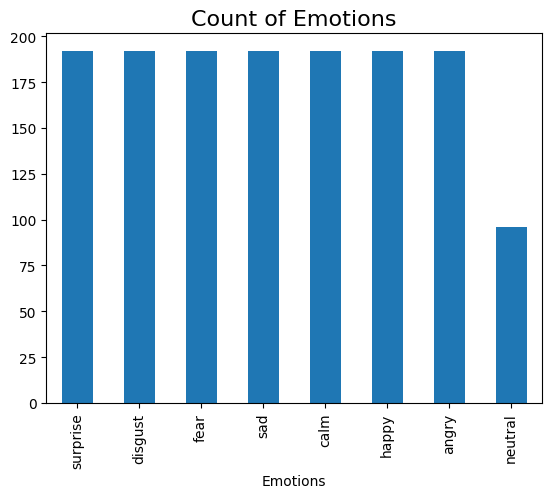

In [9]:
plt.title('Count of Emotions', size=16)
emotion_counts= data_path['Emotions'].value_counts()
emotion_counts.plot(kind='bar')
plt.show()

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

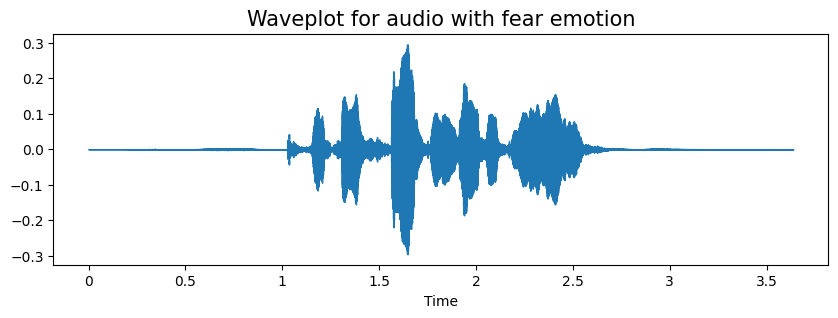

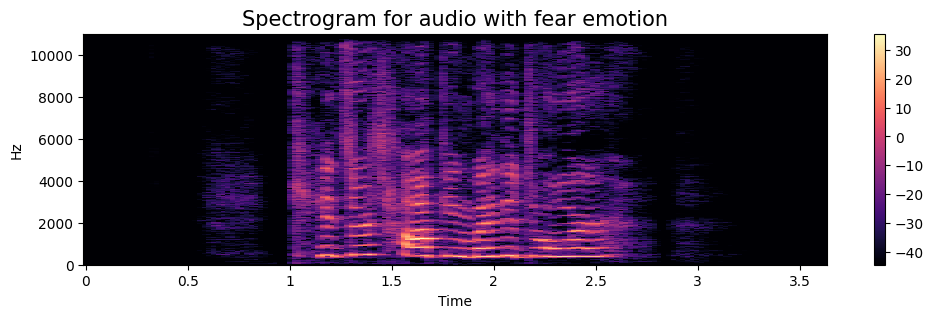

In [13]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

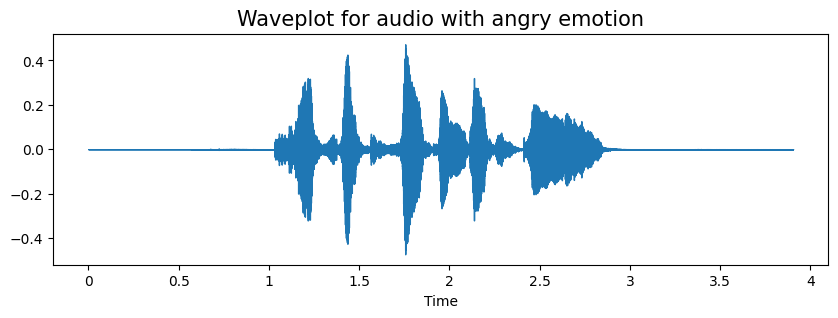

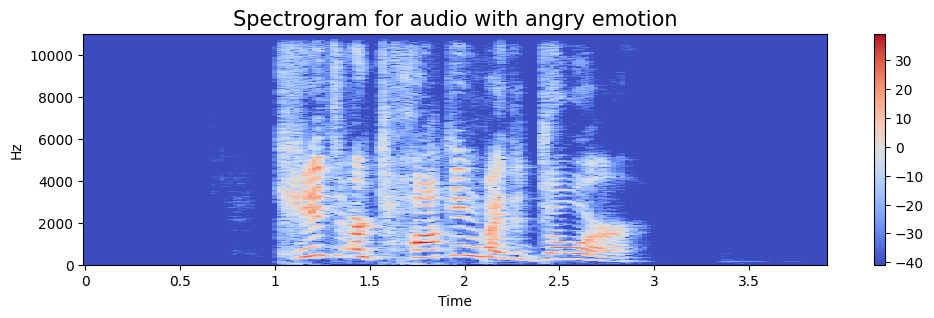

In [14]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

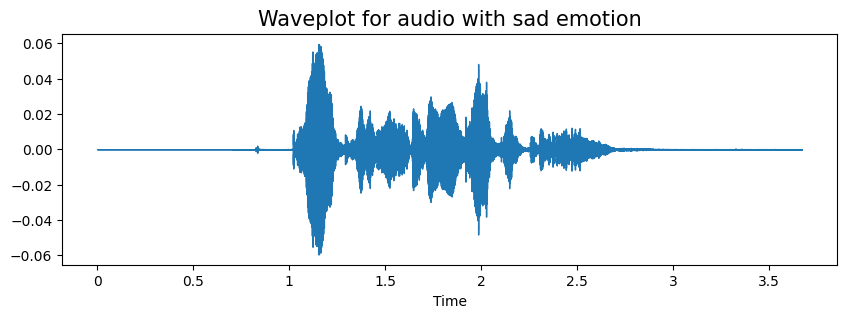

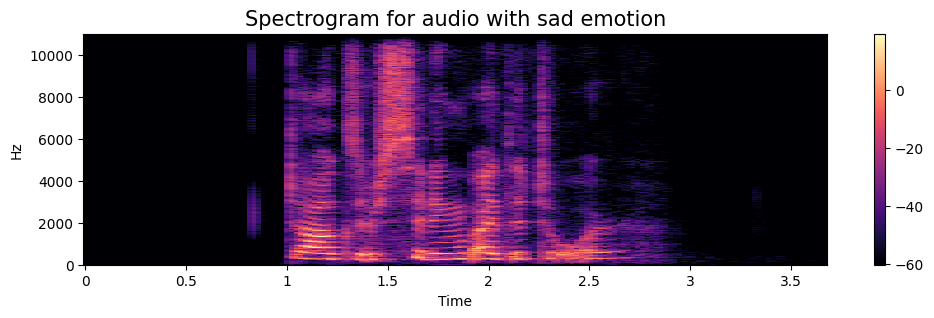

In [15]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

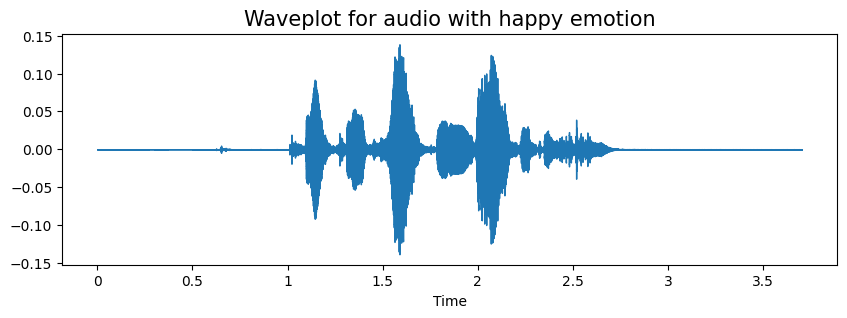

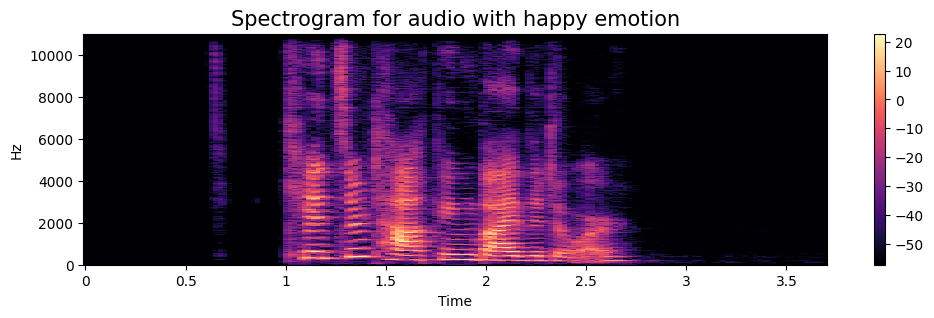

In [16]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.



In [24]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

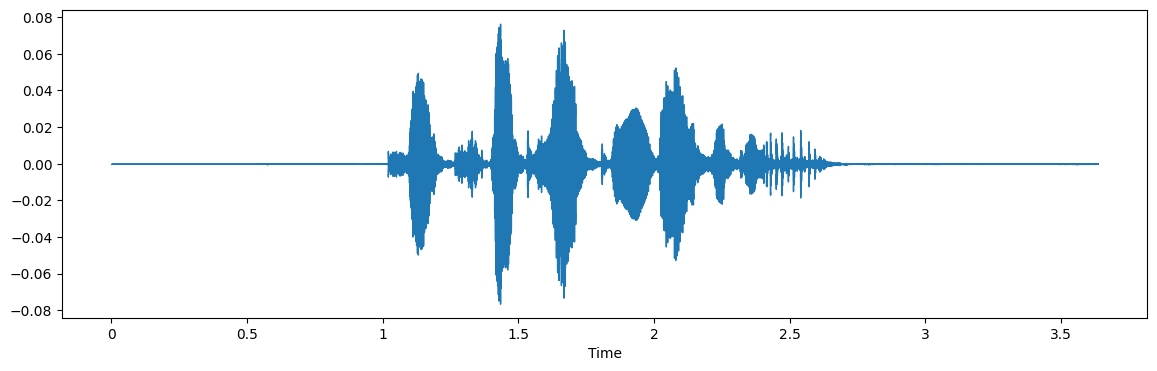

In [19]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

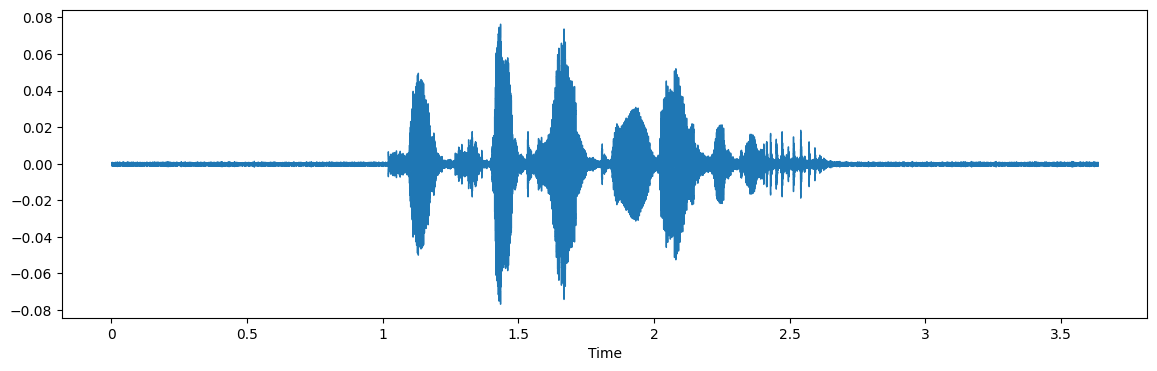

In [21]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

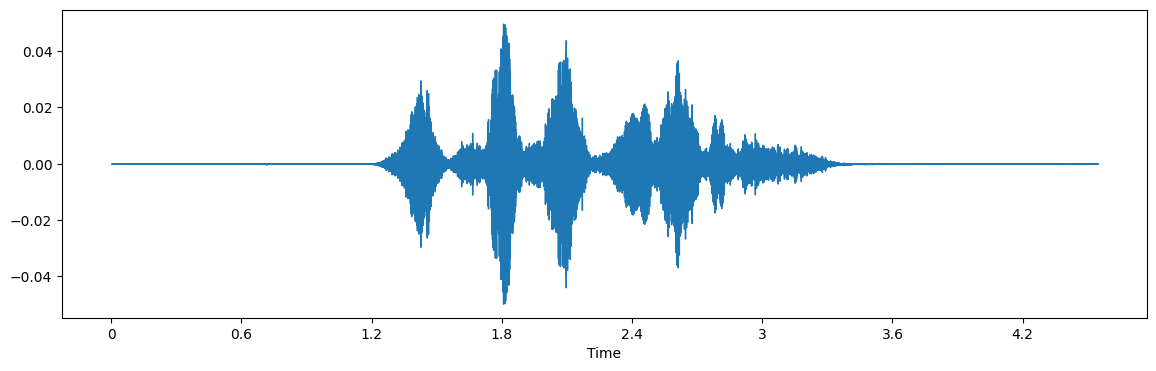

In [25]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

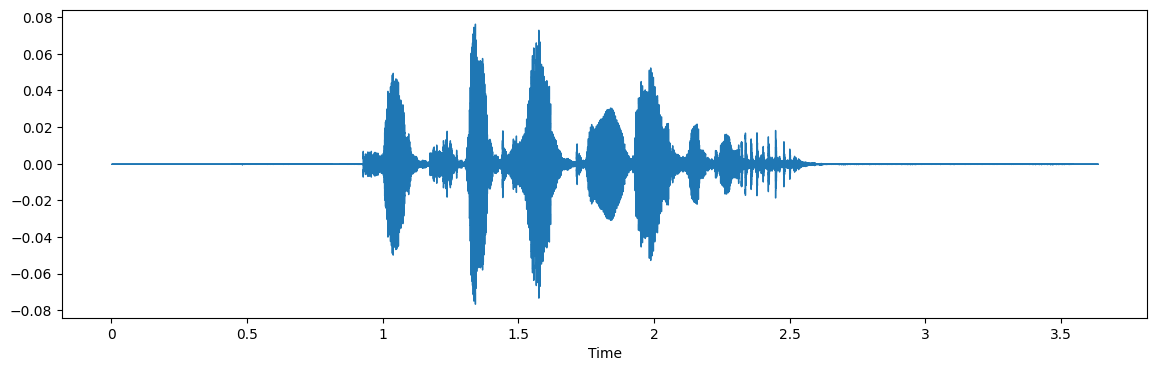

In [27]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In this project, i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [35]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    
    
    return result

In [36]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [37]:
len(X), len(Y), data_path.Path.shape

(2880, 2880, (1440,))

In [38]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.237382  0.682273  0.670519  0.614793  0.579039  0.566803  0.637206   
1  0.308558  0.704727  0.719504  0.701178  0.692597  0.706570  0.714927   
2  0.256113  0.621621  0.580278  0.598515  0.628296  0.598015  0.597272   
3  0.267257  0.637752  0.640720  0.683601  0.707169  0.675560  0.640015   
4  0.180632  0.621834  0.632666  0.567364  0.558964  0.592169  0.638070   

          7         8         9  ...       153       154       155       156  \
0  0.667451  0.663883  0.669903  ...  0.000234  0.000235  0.000138  0.000128   
1  0.707705  0.681009  0.693330  ...  0.000591  0.000567  0.000487  0.000476   
2  0.650352  0.698635  0.681863  ...  0.000018  0.000016  0.000013  0.000012   
3  0.686711  0.730228  0.698652  ...  0.000034  0.000032  0.000030  0.000029   
4  0.635625  0.634870  0.589902  ...  0.000083  0.000103  0.000160  0.000099   

        157       158       159       160           161    labels  
0  0.000299  0.000360  0.000275  0.000173  2.896729e-05  surprise  
1  0.000648  0.000735  0.000631  0.000520  3.797595e-04  surprise  
2  0.000007  0.000008  0.000008  0.000005  5.802853e-07   neutral  
3  0.000025  0.000027  0.000027  0.000021  1.737603e-05   neutral  
4  0.000060  0.000060  0.000056  0.000033  3.975709e-06   disgust  

[5 rows x 163 columns]

## Data Preparation



In [39]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [40]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [41]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162), (2160, 8), (720, 162), (720, 8))

In [42]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162), (2160, 8), (720, 162), (720, 8))

In [43]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162, 1), (2160, 8), (720, 162, 1), (720, 8))

In [44]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [45]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
34/34 [==============================] - 9s 210ms/step - loss: 1.9919 - accuracy: 0.1847 - val_loss: 1.9314 - val_accuracy: 0.2306 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 7s 199ms/step - loss: 1.9330 - accuracy: 0.2093 - val_loss: 1.8921 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 7s 211ms/step - loss: 1.8767 - accuracy: 0.2356 - val_loss: 1.8273 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 7s 199ms/step - loss: 1.8418 - accuracy: 0.2556 - val_loss: 1.7661 - val_accuracy: 0.2958 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 7s 196ms/step - loss: 1.7780 - accuracy: 0.2838 - val_loss: 1.7300 - val_accuracy: 0.3764 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 7s 198ms/step - loss: 1.7365 - accuracy: 0.3162 - val_loss: 1.6841 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - 7s 198ms/step - lo

23/23 [==============================] - 1s 23ms/step - loss: 1.6141 - accuracy: 0.5972
Accuracy of our model on test data :  59.72222089767456 %


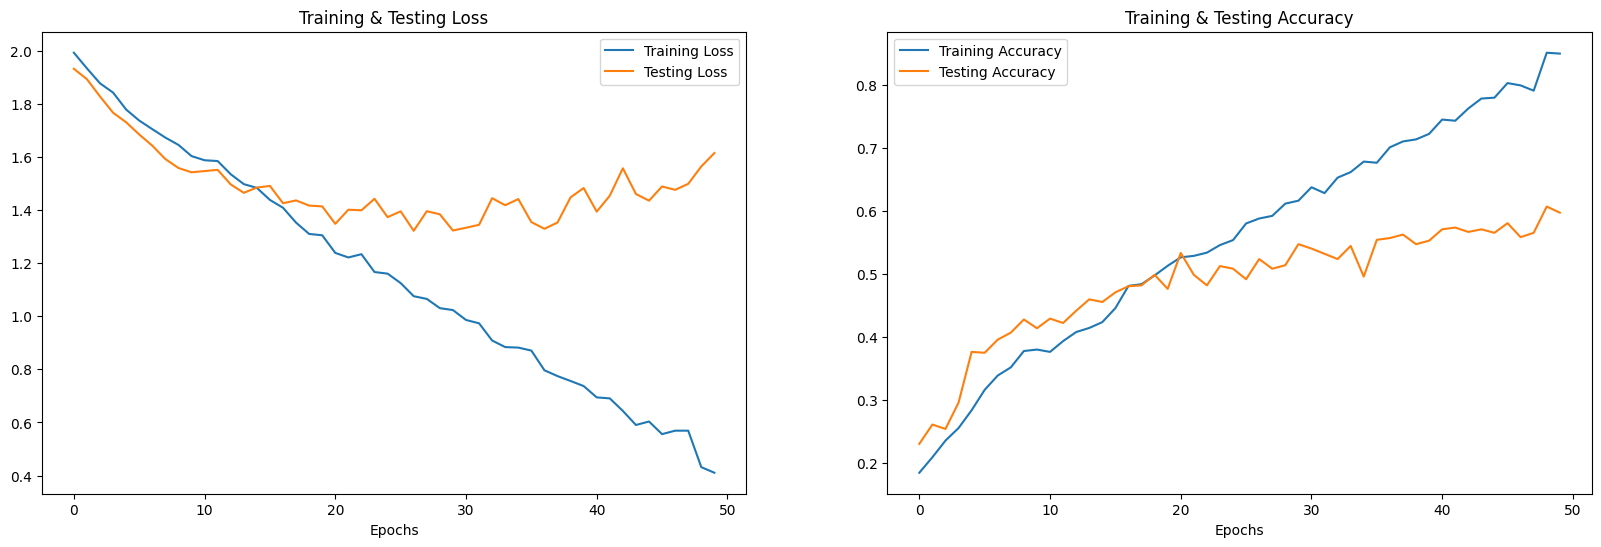

In [46]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [47]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

23/23 [==============================] - 1s 24ms/step


In [48]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1              sad           sad
2          neutral          calm
3         surprise          fear
4             calm          calm
5            happy       disgust
6          disgust       disgust
7         surprise         angry
8              sad       neutral
9            happy           sad

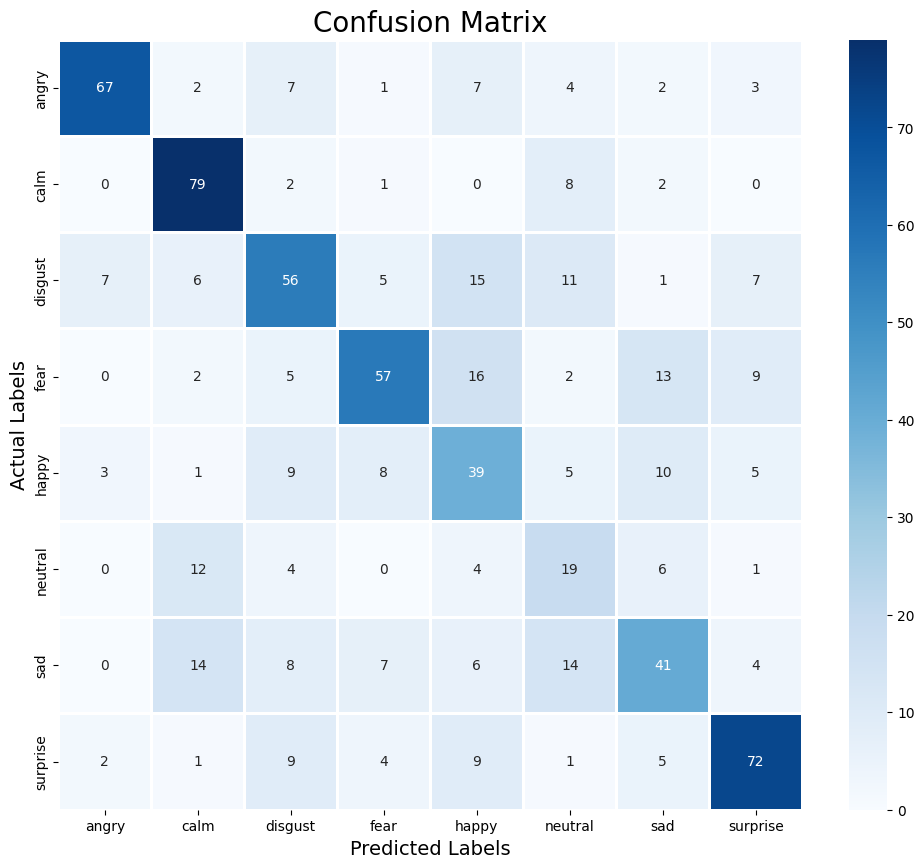

In [49]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.85      0.72      0.78        93
        calm       0.68      0.86      0.76        92
     disgust       0.56      0.52      0.54       108
        fear       0.69      0.55      0.61       104
       happy       0.41      0.49      0.44        80
     neutral       0.30      0.41      0.35        46
         sad       0.51      0.44      0.47        94
    surprise       0.71      0.70      0.71       103

    accuracy                           0.60       720
   macro avg       0.59      0.59      0.58       720
weighted avg       0.61      0.60      0.60       720

